In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/metadata.csv')
df

file        speaker  \
0      0x00112fd8      Abel Lupo   
1      0x0011dcbc      Abel Lupo   
2      0x00123394      Abel Lupo   
3      0x001131f8      Abel Lupo   
4      0x001132e1      Abel Lupo   
...           ...            ...   
63864  0x000791d0  Zoltan Chivay   
63865  0x000791ad  Zoltan Chivay   
63866  0x000791aa  Zoltan Chivay   
63867  0x000791e5  Zoltan Chivay   
63868  0x000fd912  Zoltan Chivay   

                                                    text  duration  
0      Great, isn't it? You should take this stuff mo...  5.422667  
1      First I've heard. Don't recall that ever happe...  2.332000  
2                        Geralt, please, no hocus-pocus.  2.750667  
3                        Geralt! It's the umbra! Attack!  2.265333  
4          Let's kick his astral ass, Geralt! For Blaze!  4.209333  
...                                                  ...       ...  
63864  Hah! Like to know that meself! Maybe he could ...  5.073333  
63865                                           Meaning?  0.886667  
63866                                     Ooh… not good.  2.518667  
63867                         We've a wee problem, then…  2.644000  
63868  Haha, and it tasted like thyme-flavored shite!...  5.292000  

[63869 rows x 4 columns]

In [7]:
print(f'Łączny czas trwania: {df["duration"].sum() / 3600:.2f} godzin')
print(f'Łączna liczba nagrań: {df.shape[0]}')
print(f'Łączna liczba mówców: {df["speaker"].nunique()}')

Łączny czas trwania: 69.29 godzin
Łączna liczba nagrań: 63869
Łączna liczba mówców: 1656


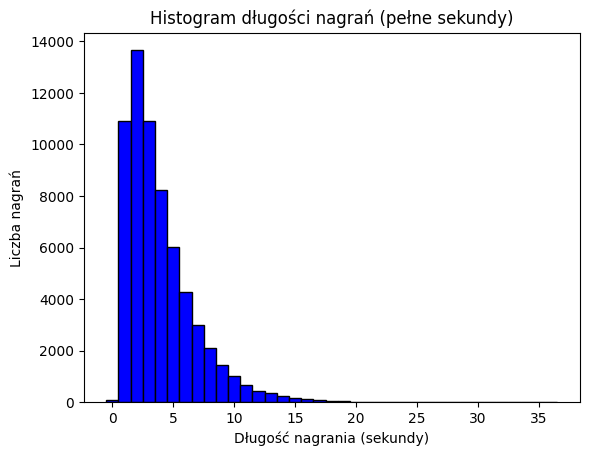

In [ ]:
import matplotlib.pyplot as plt

df['duration_rounded'] = df['duration'].round()

plt.hist(df['duration_rounded'], bins=range(int(df['duration_rounded'].min()), int(df['duration_rounded'].max()) + 2), color='blue', edgecolor='black', align='left')
plt.title('Histogram długości nagrań (pełne sekundy)')
plt.xlabel('Długość nagrania (sekundy)')
plt.ylabel('Liczba nagrań')
plt.show()

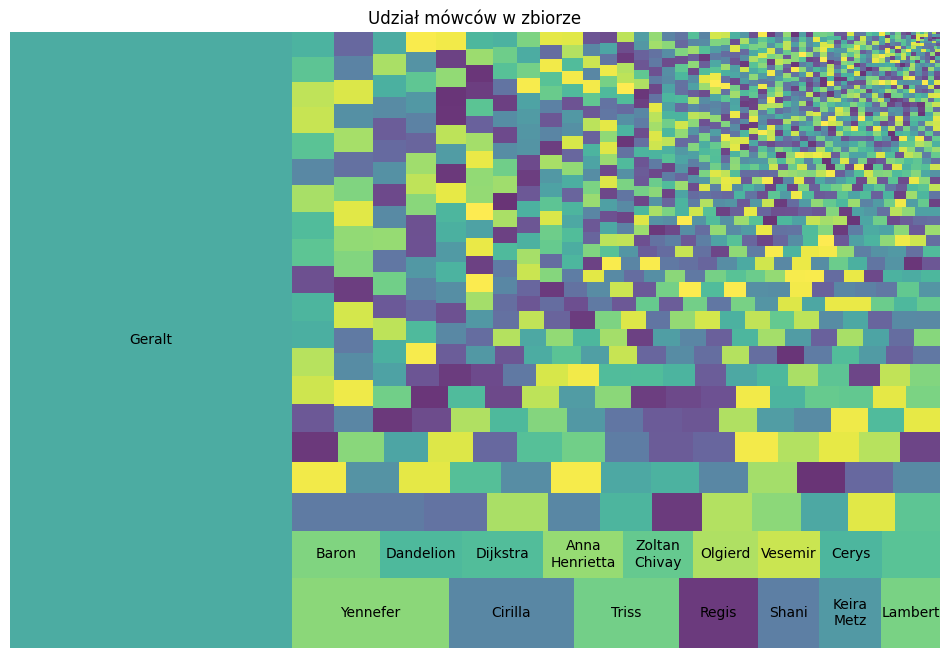

In [ ]:
import squarify

speaker_counts = df['speaker'].value_counts()
threshold = 0.005 * speaker_counts.sum()

filtered_speakers = speaker_counts[speaker_counts >= threshold]
filtered_labels = ['\n'.join(speaker.split()) for speaker in filtered_speakers.index]
filtered_sizes = filtered_speakers.values

remaining_speakers = speaker_counts[speaker_counts < threshold]
remaining_sizes = remaining_speakers.values

all_sizes = list(filtered_sizes) + list(remaining_sizes)
all_labels = list(filtered_labels) + [""] * len(remaining_sizes)

plt.figure(figsize=(12, 8))
squarify.plot(sizes=all_sizes, label=all_labels, alpha=0.8)
plt.title('Udział mówców w zbiorze')
plt.axis('off')
plt.show()

In [ ]:
from tqdm import tqdm
import torchaudio
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY = os.getenv("API_KEY")

def get_embeddings(model):
    embeddings = []
    for file in tqdm(df['file']):
        embedding = model(f'data/voices/{file}.wav')
        embeddings.append(embedding)
    return embeddings

encoder = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa", use_auth_token=API_KEY)
def model(file_path):
    audio, sr = torchaudio.load(file_path)
    audio = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(audio)
    return encoder.encode_batch(audio)

embeddings = get_embeddings(model)
embeddings = np.array(embeddings)
np.save("data/embeddings.npy", embeddings)

In [3]:
embeddings = np.load('data/embeddings.npy')

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np
import pandas as pd

def plot_embeddings(embeddings):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(np.array(embeddings))

    tsne_df = pd.DataFrame(tsne_results, columns=['x', 'y'])
    tsne_df['label'] = df['speaker']
    tsne_df['text'] = df['text']

    label_counts = tsne_df['label'].value_counts()
    sorted_labels = label_counts.index.tolist()

    fig = px.scatter(
        tsne_df,
        x='x',
        y='y',
        color='label',
        title='Wizualizacja osadzeń przy użyciu t-SNE',
        labels={'label': 'Speaker'},
        hover_name='text',
        color_discrete_sequence=px.colors.qualitative.Vivid,
        category_orders={'label': sorted_labels}
    )

    fig.update_layout(
        width=1600,
        height=1000
    )

    fig.update_traces(marker=dict(size=10), selector=dict(mode='markers'))

    fig.show()


In [10]:
plot_embeddings(embeddings)

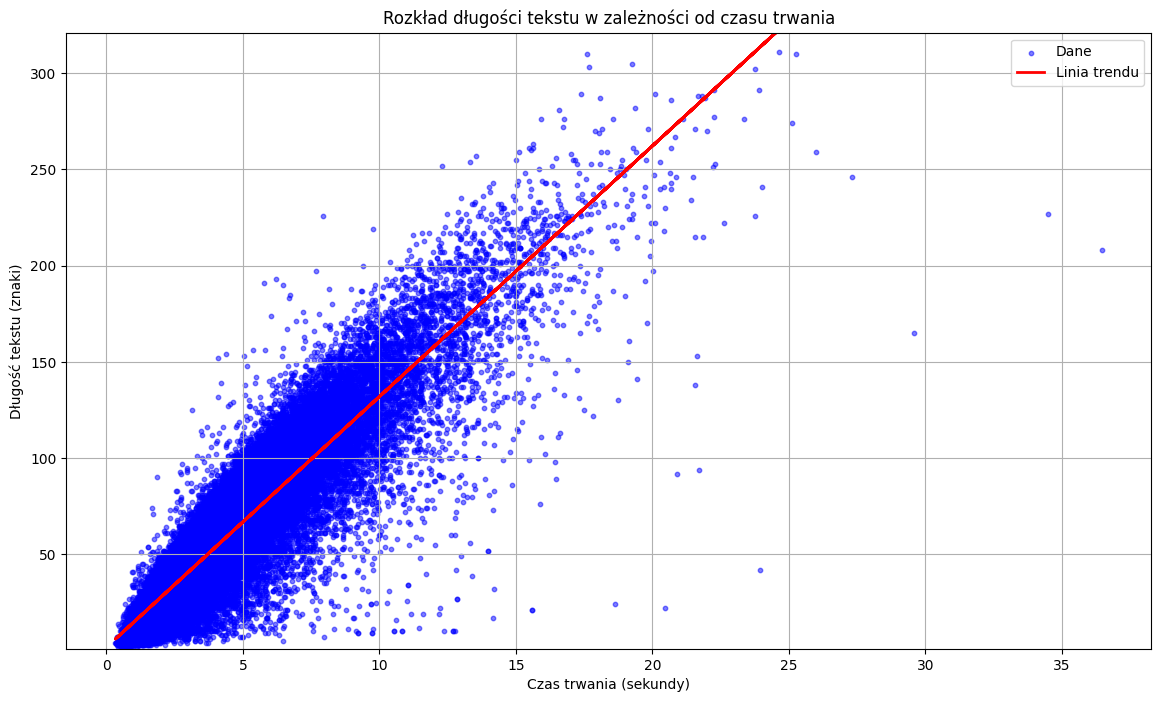

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


df['text_length'] = df['text'].apply(len)
x = df['duration']
y = df['text_length']

coeffs = np.polyfit(x, y, deg=1)
trend_line = np.poly1d(coeffs)

ymin, ymax = y.min(), y.max() + 10

plt.figure(figsize=(14, 8))
plt.scatter(x, y, alpha=0.5, color='blue', s=10, label='Dane')
plt.plot(x, trend_line(x), color='red', linewidth=2, label='Linia trendu')
plt.ylim(ymin, ymax)
plt.title('Rozkład długości tekstu w zależności od czasu trwania')
plt.xlabel('Czas trwania (sekundy)')
plt.ylabel('Długość tekstu (znaki)')
plt.grid(True)
plt.legend()
plt.show()


In [22]:
trend_line

poly1d([13.0206298 ,  1.76093238])

# Sprawdzanie możliwości transkrypcyjnych dla nagrań

In [3]:
import whisper
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
whisper_turbo = whisper.load_model("turbo", device=device)

c:\Studia\.conda\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


In [ ]:
import re
import time
import numpy as np
import pandas as pd
import librosa
import jiwer
from difflib import SequenceMatcher

def normalize_text(text):
    """ Normalizacja tekstu: małe litery, usunięcie interpunkcji, nadmiarowych spacji """
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def test_transcription(df, model):
    sim_list = []
    wer_list = []
    cer_list = []
    norm_sim_list = []
    norm_wer_list = []
    norm_cer_list = []
    sim_list2 = []
    wer_list2 = []
    cer_list2 = []
    norm_sim_list2 = []
    norm_wer_list2 = []
    norm_cer_list2 = []

    passed_rows = []

    for i, row in tqdm(list(df.iterrows())):
        wav = librosa.load(f'data/voices/{row["file"]}.wav', sr=16000)[0]

        result = model.transcribe(wav, without_timestamps=True, language='en')
        gen_text = result['text'].strip()

        sim = SequenceMatcher(None, row['text'], gen_text).ratio()
        wer = jiwer.wer(row['text'], gen_text)
        cer = jiwer.cer(row['text'], gen_text)
        sim_list.append(sim)
        wer_list.append(wer)
        cer_list.append(cer)

        ref_norm = normalize_text(row['text'])
        gen_norm = normalize_text(gen_text)

        norm_sim = SequenceMatcher(None, ref_norm, gen_norm).ratio()
        norm_wer = jiwer.wer(ref_norm, gen_norm)
        norm_cer = jiwer.cer(ref_norm, gen_norm)
        norm_sim_list.append(norm_sim)
        norm_wer_list.append(norm_wer)
        norm_cer_list.append(norm_cer)

        if norm_cer <= 0.1:
            passed_rows.append(row)
            sim_list2.append(sim)
            wer_list2.append(wer)
            cer_list2.append(cer)
            norm_sim_list2.append(norm_sim)
            norm_wer_list2.append(norm_wer)
            norm_cer_list2.append(norm_cer)

    results = pd.DataFrame({
        'original': [
            np.mean(sim_list),
            np.mean(wer_list),
            np.mean(cer_list),
        ],
        'normalized': [
            np.mean(norm_sim_list),
            np.mean(norm_wer_list),
            np.mean(norm_cer_list),
        ],
        'filtered_original': [
            np.mean(sim_list2),
            np.mean(wer_list2),
            np.mean(cer_list2),
        ],
        'filtered_normalized': [
            np.mean(norm_sim_list2),
            np.mean(norm_wer_list2),
            np.mean(norm_cer_list2),
        ]
    }, index=['sim', 'wer', 'cer'])

    passed_df = pd.DataFrame(passed_rows)

    return results, passed_df



In [11]:
results, filtered_df = test_transcription(df[(df['duration'] >= 2) & (df['duration'] <= 10)], whisper_turbo)
results

100%|██████████| 43185/43185 [3:54:39<00:00,  3.07it/s]   


original  normalized  filtered_original  filtered_normalized
sim  0.932360    0.962058           0.962400             0.988957
wer  0.252385    0.124764           0.185517             0.056759
cer  0.088293    0.057331           0.046122             0.017080

In [12]:
filtered_df

file        speaker  \
0      0x00112fd8      Abel Lupo   
1      0x0011dcbc      Abel Lupo   
2      0x00123394      Abel Lupo   
3      0x001131f8      Abel Lupo   
4      0x001132e1      Abel Lupo   
...           ...            ...   
63862  0x000791d2  Zoltan Chivay   
63863  0x0007f0f3  Zoltan Chivay   
63864  0x000791d0  Zoltan Chivay   
63866  0x000791aa  Zoltan Chivay   
63867  0x000791e5  Zoltan Chivay   

                                                    text  duration  
0      Great, isn't it? You should take this stuff mo...  5.422667  
1      First I've heard. Don't recall that ever happe...  2.332000  
2                        Geralt, please, no hocus-pocus.  2.750667  
3                        Geralt! It's the umbra! Attack!  2.265333  
4          Let's kick his astral ass, Geralt! For Blaze!  4.209333  
...                                                  ...       ...  
63862  Dandelion gone, the tavern chock full of bums....  5.134667  
63863  I brought this Mahakaman mix - flammable as bo...  6.497333  
63864  Hah! Like to know that meself! Maybe he could ...  5.073333  
63866                                     Ooh… not good.  2.518667  
63867                         We've a wee problem, then…  2.644000  

[37534 rows x 4 columns]

In [11]:
df[(df['duration'] >= 2) & (df['duration'] <= 10)]

file        speaker  \
0      0x00112fd8      Abel Lupo   
1      0x0011dcbc      Abel Lupo   
2      0x00123394      Abel Lupo   
3      0x001131f8      Abel Lupo   
4      0x001132e1      Abel Lupo   
...           ...            ...   
63863  0x0007f0f3  Zoltan Chivay   
63864  0x000791d0  Zoltan Chivay   
63866  0x000791aa  Zoltan Chivay   
63867  0x000791e5  Zoltan Chivay   
63868  0x000fd912  Zoltan Chivay   

                                                    text  duration  
0      Great, isn't it? You should take this stuff mo...  5.422667  
1      First I've heard. Don't recall that ever happe...  2.332000  
2                        Geralt, please, no hocus-pocus.  2.750667  
3                        Geralt! It's the umbra! Attack!  2.265333  
4          Let's kick his astral ass, Geralt! For Blaze!  4.209333  
...                                                  ...       ...  
63863  I brought this Mahakaman mix - flammable as bo...  6.497333  
63864  Hah! Like to know that meself! Maybe he could ...  5.073333  
63866                                     Ooh… not good.  2.518667  
63867                         We've a wee problem, then…  2.644000  
63868  Haha, and it tasted like thyme-flavored shite!...  5.292000  

[43185 rows x 4 columns]

# Podział danych

In [34]:
filtered_df_limited = filtered_df.groupby('speaker').apply(lambda x: x.sample(min(len(x), 1000), random_state=42)).reset_index(drop=True)
filtered_df_limited

file        speaker  \
0      0x0011d9e8      Abel Lupo   
1      0x0011dca2      Abel Lupo   
2      0x0011331c      Abel Lupo   
3      0x0011d9ef      Abel Lupo   
4      0x001132e1      Abel Lupo   
...           ...            ...   
26681  0x000fd805  Zoltan Chivay   
26682  0x000fe6ec  Zoltan Chivay   
26683  0x000fd5f1  Zoltan Chivay   
26684  0x0007bbdf  Zoltan Chivay   
26685  0x000fd8e3  Zoltan Chivay   

                                                    text  duration  
0      Thanks, Captain Obvious. Now what about the sm...  8.473333  
1                 What the fuck do you think I'm doing?!  3.129333  
2      This is a killer. Why'd the horse cross the road?  2.692000  
3      Geralt, please, I got this. It's definitely an...  6.769333  
4          Let's kick his astral ass, Geralt! For Blaze!  4.209333  
...                                                  ...       ...  
26681  Now we collect a shiteload o' coin for them. L...  3.916000  
26682  Fringilla Vigo, Isengrim, and John Natalis. De...  8.793333  
26683  Excellent! Now we've just Caesar Bilzen to fle...  6.510667  
26684     Don't give a flyin' fuck what you wanted! Get!  3.188000  
26685  Fringilla Vigo, Isengrim, and John Natalis. De...  8.873333  

[26686 rows x 4 columns]

In [35]:
import random
speakers = filtered_df_limited['speaker'].unique()
random.seed(42)
random.shuffle(speakers)
part_0_speakers = []
part_0_count = 0
total_count = filtered_df_limited.shape[0]

for speaker in speakers:
    part_0_speakers.append(speaker)
    part_0_count += filtered_df_limited[filtered_df_limited['speaker'] == speaker].shape[0]
    if part_0_count >= total_count / 2:
        break

part_0 = filtered_df_limited[filtered_df_limited['speaker'].isin(part_0_speakers)] 
part_1 = filtered_df_limited[~filtered_df_limited['speaker'].isin(part_0_speakers)]

print(f'Liczba nagrań w części 0: {part_0.shape[0]}')
print(f'Liczba nagrań w części 1: {part_1.shape[0]}')
print(f'Liczba unikalnych mówców w części 0: {part_0["speaker"].nunique()}')
print(f'Liczba unikalnych mówców w części 1: {part_1["speaker"].nunique()}')


Liczba nagrań w części 0: 13509
Liczba nagrań w części 1: 13177
Liczba unikalnych mówców w części 0: 744
Liczba unikalnych mówców w części 1: 582


In [36]:
part_0.to_csv('data/metadata_val.csv', index=False)
part_1.to_csv('data/metadata_test.csv', index=False)

In [ ]:
file_to_index = {file: idx for idx, file in enumerate(df['file'])}

indices_part_0 = [file_to_index[file] for file in part_0['file']]
indices_part_1 = [file_to_index[file] for file in part_1['file']]

embeddings_part_0 = embeddings[indices_part_0]
embeddings_part_1 = embeddings[indices_part_1]

np.save("data/embeddings_val.npy", embeddings_part_0)
np.save("data/embeddings_test.npy", embeddings_part_1)

Liczba embeddingów w part_0: 13509
Liczba embeddingów w part_1: 13177
